In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [5]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [6]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

#### Declarando as funções de avaliação do modelo

In [7]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [8]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [10]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [11]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [12]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [13]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [14]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [15]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo xgboost base

Utilizaremos configurações similares a configuração base do random forest, para comparação

In [16]:
params = {
    'max_depth': 10,
    'eta': 0.1,  #Learning Rate
    'objective': 'binary:logistic', # Escolha para classificação binária
    'eval_metric': 'auc'            # Avaliando via AUC
}

##### Criando instância DMatrix

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [21]:
model = xgb.train(params, dtrain, 50, evals=[(dval, 'validation')], early_stopping_rounds=5)


[0]	validation-auc:0.98732
[1]	validation-auc:0.98779
[2]	validation-auc:0.98877
[3]	validation-auc:0.98898
[4]	validation-auc:0.98917
[5]	validation-auc:0.98932
[6]	validation-auc:0.98960
[7]	validation-auc:0.98976
[8]	validation-auc:0.99003
[9]	validation-auc:0.99028
[10]	validation-auc:0.99051
[11]	validation-auc:0.99060
[12]	validation-auc:0.99083
[13]	validation-auc:0.99097
[14]	validation-auc:0.99113
[15]	validation-auc:0.99124
[16]	validation-auc:0.99158
[17]	validation-auc:0.99179
[18]	validation-auc:0.99194
[19]	validation-auc:0.99204
[20]	validation-auc:0.99219
[21]	validation-auc:0.99229
[22]	validation-auc:0.99244
[23]	validation-auc:0.99254
[24]	validation-auc:0.99262
[25]	validation-auc:0.99268
[26]	validation-auc:0.99275
[27]	validation-auc:0.99281
[28]	validation-auc:0.99289
[29]	validation-auc:0.99293
[30]	validation-auc:0.99299
[31]	validation-auc:0.99303
[32]	validation-auc:0.99306
[33]	validation-auc:0.99308
[34]	validation-auc:0.99313
[35]	validation-auc:0.99314
[3

#### Avaliando o Modelo


In [39]:
xgb_pred_scores = model.predict(dtest)

# Calculando a probabilidade da classe negativa
neg_class_probs = 1 - xgb_pred_scores

# Concatenando as duas arrays para formar um array 2D
xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

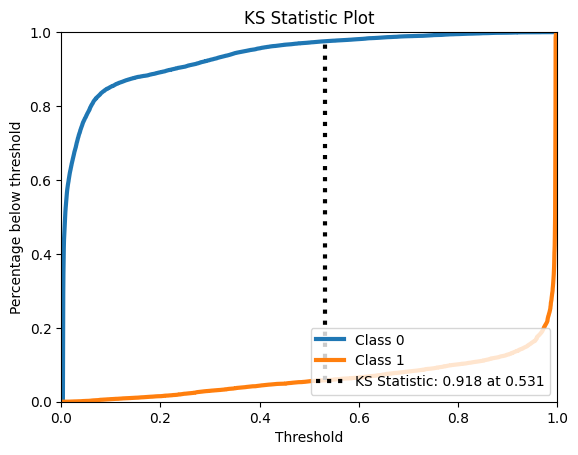



xgboost - Test

Accuracy:         0.9599
Recall:           0.9445
Precision:        0.9625
F1:               0.9534
AUROC:            0.9942
AUPR:             0.9932


In [42]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
print('\n\nxgboost - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)